# 从零实现CART(分类和回归树)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## 基尼系数

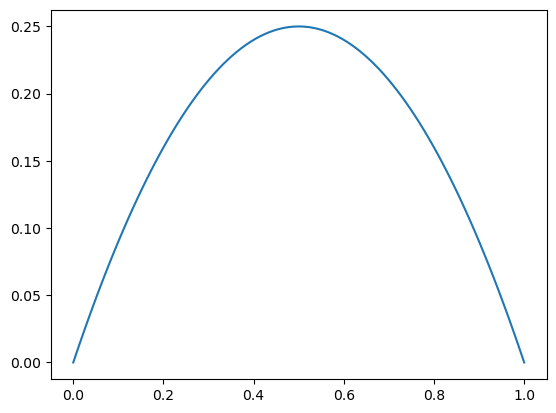

In [11]:
p = np.linspace(0, 1, 100)
plt.plot(p, p*(1-p))
plt.show()

## 1. 回归树

### 1.1 数据准备

> 使用加利福尼亚州不同街区的房价数据构建决策树模型

In [12]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [13]:
y = data.target.reshape(-1, 1)
X = df.values

In [14]:
X.shape, y.shape

((20640, 8), (20640, 1))

### 1.2 划分数据集

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 1.3 构建模型

In [16]:
class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth):
        # 终止条件：深度限制或样本数小于最小拆分样本数
        if len(y) < self.min_samples_split or depth == self.max_depth:
            return {'value': np.mean(y)}

        # 初始化最优分割参数
        best_feature, best_threshold, best_mse = None, None, float('inf')

        # 遍历所有特征和分割点
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                # 根据分割点分左右子树
                left_idx = X[:, feature_index] <= threshold
                right_idx = X[:, feature_index] > threshold

                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue

                mse = self._calculate_mse(y[left_idx], y[right_idx])

                if mse < best_mse:
                    best_feature = feature_index
                    best_threshold = threshold
                    best_mse = mse

        if best_feature is None:
            return {'value': np.mean(y)}

        # 根据最优分割点递归构建子树
        left_idx = X[:, best_feature] <= best_threshold
        right_idx = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def _calculate_mse(self, left_y, right_y):
        """计算均方误差"""
        left_mse = np.mean((left_y - np.mean(left_y)) ** 2) if len(left_y) > 0 else 0
        right_mse = np.mean((right_y - np.mean(right_y)) ** 2) if len(right_y) > 0 else 0
        return (len(left_y) * left_mse + len(right_y) * right_mse) / (len(left_y) + len(right_y))

    def _predict_sample(self, x, tree):
        """预测单个样本"""
        if 'value' in tree:
            return tree['value']

        feature = tree['feature']
        threshold = tree['threshold']

        if x[feature] <= threshold:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

In [17]:
# 训练自定义回归决策树
tree = DecisionTreeRegressor(max_depth=5, min_samples_split=10)
tree.fit(X_train, y_train)

# 预测
y_pred = tree.predict(X_test)

# 计算误差
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 0.52


In [18]:
y_test, y_pred

(array([[0.477  ],
        [0.458  ],
        [5.00001],
        ...,
        [5.00001],
        [0.723  ],
        [1.515  ]]),
 array([1.16857267, 1.27158128, 3.19958174, ..., 4.86065073, 1.27158128,
        1.64279735]))